In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import ast

artists_df = pd.read_csv('artists.csv')
relationships_df = pd.read_csv('relationships.csv')
institutions_df = pd.read_csv('institutions.csv')
schools_df = pd.read_csv('schools.csv')

def safe_literal_eval(value):
    try:
        if pd.isnull(value):
            return []
        return ast.literal_eval(value)
    except (ValueError, SyntaxError):
        return []

# Apply the safe conversion
relationships_df['friends'] = relationships_df['friends'].apply(safe_literal_eval)
relationships_df['influenced_by'] = relationships_df['influenced_by'].apply(safe_literal_eval)
relationships_df['influenced_on'] = relationships_df['influenced_on'].apply(safe_literal_eval)

# Converting `school` and `institution` columns
relationships_df['school'] = relationships_df['school'].apply(lambda x: [] if pd.isnull(x) else str(x).split(','))
relationships_df['institution'] = relationships_df['institution'].apply(lambda x: [] if pd.isnull(x) else str(x).split(','))

# Check for missing values
missing_values = {
    'artists_df': artists_df.isnull().sum(),
    'relationships_df': relationships_df.isnull().sum(),
    'institutions_df': institutions_df.isnull().sum(),
    'schools_df': schools_df.isnull().sum()
}

print("=== Missing Values in DataFrames ===")
for name, mv in missing_values.items():
    mv_filtered = mv[mv > 0]
    if not mv_filtered.empty:
        print(f"Missing Values in {name}:")
        print(mv_filtered)
        print("\n")
    else:
        print(f"No missing values in {name}\n")

print("\n=== Data Distributions ===")
print("\nArtists Nationality Distribution:")
print(artists_df['nation'].value_counts().head(10))

# Convert `totalWorksTitle` to numerical values and display distribution
artists_df['totalWorksTitle'] = artists_df['totalWorksTitle'].str.extract('(\d+)').astype(float).fillna(0)
print("\nDistribution of Total Artworks by Artists:")
print(artists_df['totalWorksTitle'].describe())

=== Missing Values in DataFrames ===
Missing Values in artists_df:
nation    32
year       1
dtype: int64


Missing Values in relationships_df:
movements    40
type          1
dtype: int64


Missing Values in institutions_df:
city       2
country    2
dtype: int64


No missing values in schools_df


=== Data Distributions ===

Artists Nationality Distribution:
nation
American    520
French      402
Italian     269
British     249
German      160
Russian     108
Dutch       105
Spanish      87
Romanian     78
Japanese     67
Name: count, dtype: int64

Distribution of Total Artworks by Artists:
count    2996.000000
mean       57.140521
std       109.972460
min         0.000000
25%        16.000000
50%        27.000000
75%        55.000000
max      1931.000000
Name: totalWorksTitle, dtype: float64


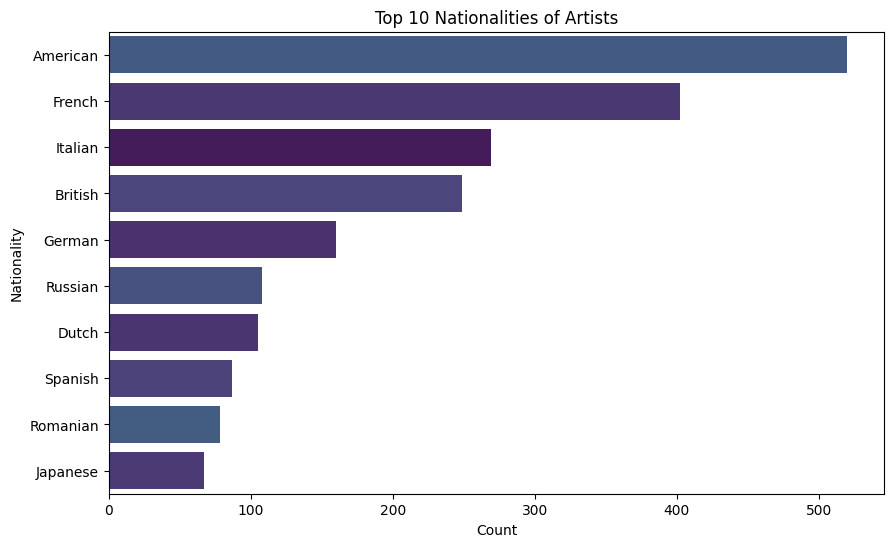

In [13]:
plt.figure(figsize=(10, 6))
sns.countplot(
    y=artists_df['nation'],
    order=artists_df['nation'].value_counts().index[:10],
    hue=artists_df['nation'],
    palette='viridis',
    legend=False
    )
plt.title('Top 10 Nationalities of Artists')
plt.xlabel('Count')
plt.ylabel('Nationality')
plt.show()

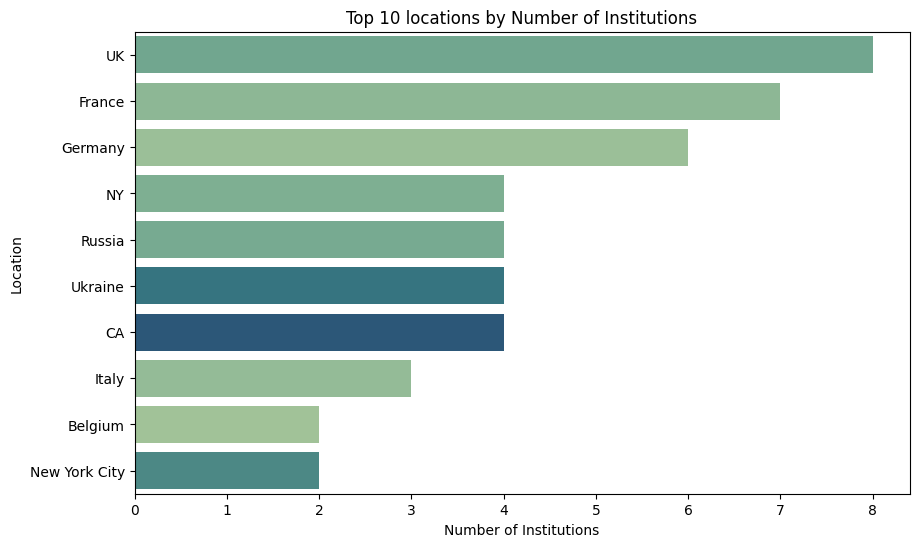

In [23]:
plt.figure(figsize=(10, 6))
sns.countplot(
    y=institutions_df['country'],
    order=institutions_df['country'].value_counts().index[:10],
    hue=institutions_df['country'],
    palette='crest',
    legend=False
)
plt.title('Top 10 Locations by Number of Institutions')
plt.xlabel('Number of Institutions')
plt.ylabel('Location')
plt.show()

In [43]:
import networkx as nx
import plotly.graph_objects as go
import numpy as np

# Step 2: Create a NetworkX graph
G = nx.DiGraph()
#adding nodes
for _, row in artists_df.iterrows():
    artist_id = row['id']
    G.add_node(artist_id, artistUrl=row['artistUrl'], title=row['title'], nation=row['nation'],
               total_artworks=row['totalWorksTitle'], year=row['year'], type='artist')

for _, row in institutions_df.iterrows():
    institution_id = f"inst_{row['url']}"
    G.add_node(institution_id, title=row['title'], city=row['city'], country=row['country'], type='institution')

for _, row in schools_df.iterrows():
    school_id = f"school_{row['url']}"
    G.add_node(school_id, title=row['title'], type='school')

for _, row in relationships_df.iterrows():
    artist_url = row['artistUrl']
    artist_id = artists_df[artists_df['artistUrl'] == artist_url]['id'].values
    if len(artist_id) == 0:
        continue
    artist_id = artist_id[0]

    # Connect to schools
    for school_url in row['school']:
        school_id = f"school_{school_url.strip()}"
        if school_id in G:
            G.add_edge(artist_id, school_id, relationship='attended_school')

    # Connect to institutions
    for institution_url in row['institution']:
        institution_id = f"inst_{institution_url.strip()}"
        if institution_id in G:
            G.add_edge(artist_id, institution_id, relationship='studied_at')

# Adding influence and friendship edges
for _, row in relationships_df.iterrows():
    artist_url = row['artistUrl']
    artist_id = artists_df[artists_df['artistUrl'] == artist_url]['id'].values
    if len(artist_id) == 0:
        continue
    artist_id = artist_id[0]

    # Influence relationships
    for influenced_by_url in row['influenced_by']:
        influenced_by_id = artists_df[artists_df['artistUrl'] == influenced_by_url.strip()]['id'].values
        if len(influenced_by_id) > 0:
            G.add_edge(influenced_by_id[0], artist_id, relationship='influenced_by')

    for influenced_on_url in row['influenced_on']:
        influenced_on_id = artists_df[artists_df['artistUrl'] == influenced_on_url.strip()]['id'].values
        if len(influenced_on_id) > 0:
            G.add_edge(artist_id, influenced_on_id[0], relationship='influenced_on')

    # Friendships
    for friend_url in row['friends']:
        friend_id = artists_df[artists_df['artistUrl'] == friend_url.strip()]['id'].values
        if len(friend_id) > 0:
            G.add_edge(artist_id, friend_id[0], relationship='friend')
            G.add_edge(friend_id[0], artist_id, relationship='friend')

#Display network statistics
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
print(f"Total nodes in the network: {num_nodes}")
print(f"Total edges in the network: {num_edges}")
print("\n")

#Highlighting influential nodes using degree centrality
degree_centrality = nx.degree_centrality(G)
max_centrality = max(degree_centrality.values())
node_sizes = [10 + 40 * (degree_centrality[node] / max_centrality) if node in degree_centrality else 10 for node in G.nodes()]

# 3D positions for the nodes
pos_3d = nx.spring_layout(G, dim=3, k=0.5)

# Create scatter traces
edge_x = []
edge_y = []
edge_z = []
for edge in G.edges():
    x0, y0, z0 = pos_3d[edge[0]]
    x1, y1, z1 = pos_3d[edge[1]]
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)
    edge_z.append(z0)
    edge_z.append(z1)
    edge_z.append(None)

edge_trace = go.Scatter3d(
    x=edge_x, y=edge_y, z=edge_z,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines'
)

# Scatter traces for nodes with colors and sizes reflecting centrality
node_x = []
node_y = []
node_z = []
node_text = []
node_color = []
for node in G.nodes():
    x, y, z = pos_3d[node]
    node_x.append(x)
    node_y.append(y)
    node_z.append(z)
    node_text.append(G.nodes[node]['title'])

    if G.nodes[node]['type'] == 'artist':
        node_color.append('rgba(0, 0, 255, 0.9)' if degree_centrality.get(node, 0) > 0.1 * max_centrality else 'rgba(0, 0, 255, 0.5)')
    elif G.nodes[node]['type'] == 'institution':
        node_color.append('rgba(0, 128, 0, 0.9)' if degree_centrality.get(node, 0) > 0.1 * max_centrality else 'rgba(0, 128, 0, 0.5)')
    elif G.nodes[node]['type'] == 'school':
        node_color.append('rgba(255, 0, 0, 0.9)' if degree_centrality.get(node, 0) > 0.1 * max_centrality else 'rgba(255, 0, 0, 0.5)')

node_trace = go.Scatter3d(
    x=node_x, y=node_y, z=node_z,
    mode='markers',
    marker=dict(
        size=node_sizes,
        color=node_color,
        opacity=0.8
    ),
    text=node_text,
    hoverinfo='text'
)

# Display visualization
fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(
                    title='Network Visualization',
                    showlegend=False,
                    margin=dict(b=20, l=20, r=20, t=20),
                    scene=dict(
                        xaxis=dict(showbackground=False),
                        yaxis=dict(showbackground=False),
                        zaxis=dict(showbackground=False)
                    )
                ))

fig.show()


Total nodes in the network: 3289
Total edges in the network: 1970




In [25]:
import networkx as nx
from collections import Counter
import community.community_louvain as community_louvain

# Step 3: Perform network analysis

# Centrality measures to identify influential nodes
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
largest_cc = max(nx.strongly_connected_components(G), key=len)
G_largest = G.subgraph(largest_cc)
eigenvector_centrality = nx.eigenvector_centrality(G_largest)


artist_centralities = {
    'Degree Centrality': sorted([(G.nodes[node]['title'], value) for node, value in degree_centrality.items() if G.nodes[node]['type'] == 'artist'], key=lambda x: x[1], reverse=True)[:10],
    'Betweenness Centrality': sorted([(G.nodes[node]['title'], value) for node, value in betweenness_centrality.items() if G.nodes[node]['type'] == 'artist'], key=lambda x: x[1], reverse=True)[:10],
    'Eigenvector Centrality': sorted([(G_largest.nodes[node]['title'], value) for node, value in eigenvector_centrality.items() if G.nodes[node]['type'] == 'artist'], key=lambda x: x[1], reverse=True)[:10]
}

#Most influential artists
print("1. Most Influential Artists (Top 10 by Different Centrality Measures):")
for measure, artists in artist_centralities.items():
    print(f"\nTop 10 Artists by {measure}:")
    for artist, value in artists:
        print(f"{artist}: {value:.4f}")

# Most influential movements (schools)
school_connections = Counter()
for node, data in G.nodes(data=True):
    if data['type'] == 'school':
        for neighbor in G.neighbors(node):
            if G.nodes[neighbor]['type'] == 'artist':
                school_connections[node] += 1

top_schools = school_connections.most_common(10)
print("\n2. Most Influential Movements (Top 10 by Number of Artist Connections):")
for school, count in top_schools:
    print(f"{G.nodes[school]['title']}: {count} connections")

# Most influential institutions
institution_degree_centrality = {node: centrality for node, centrality in degree_centrality.items() if G.nodes[node]['type'] == 'institution'}
top_institutions = sorted(institution_degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]

print("\n3. Most Influential Institutions (Top 10 by Degree Centrality):")
for node, value in top_institutions:
    print(f"{G.nodes[node]['title']}: {value:.4f}")

# Nationalities with the majority of artists
nationality_counts = pd.Series([G.nodes[node]['nation'] for node in G.nodes if G.nodes[node]['type'] == 'artist']).value_counts()
print("\n4. Nationalities Concentrating the Majority of Artists (Top 10):")
print(nationality_counts.head(10))

# Largest communities
partition = community_louvain.best_partition(G.to_undirected())
community_sizes = Counter(partition.values())
print("\n5. Biggest Communities in the Network (Top 5 by Number of Nodes):")
for community, size in community_sizes.most_common(5):
    print(f"Community {community}: {size} nodes")

nx.set_node_attributes(G, partition, 'community')


1. Most Influential Artists (Top 10 by Different Centrality Measures):

Top 10 Artists by Degree Centrality:
William Merritt Chase: 0.0021
Marc Chagall: 0.0021
John Henry Twachtman: 0.0018
Jacques Lipchitz: 0.0018
Childe Hassam: 0.0015
Józef Mehoffer: 0.0015
Emily Carr: 0.0015
Kazimir Malevich: 0.0015
Paul Klee: 0.0015
Fernand Leger: 0.0015

Top 10 Artists by Betweenness Centrality:
Ancient Egypt: 0.0000
Ancient Greek Pottery: 0.0000
Ancient Greek Painting and Sculpture: 0.0000
Apelles: 0.0000
Fayum portrait: 0.0000
Orthodox Icons: 0.0000
Wu Daozi: 0.0000
Wang Wei: 0.0000
Han Gan: 0.0000
Chen Hong: 0.0000

Top 10 Artists by Eigenvector Centrality:
Ancient Egypt: 1.0000

2. Most Influential Movements (Top 10 by Number of Artist Connections):

3. Most Influential Institutions (Top 10 by Degree Centrality):
École des Beaux-Arts: 0.0246
Académie Julian: 0.0161
Art Students League of New York: 0.0155
Akademie der Bildenden Künste München (Munich Academy): 0.0109
Imperial Academy of Arts: 0.

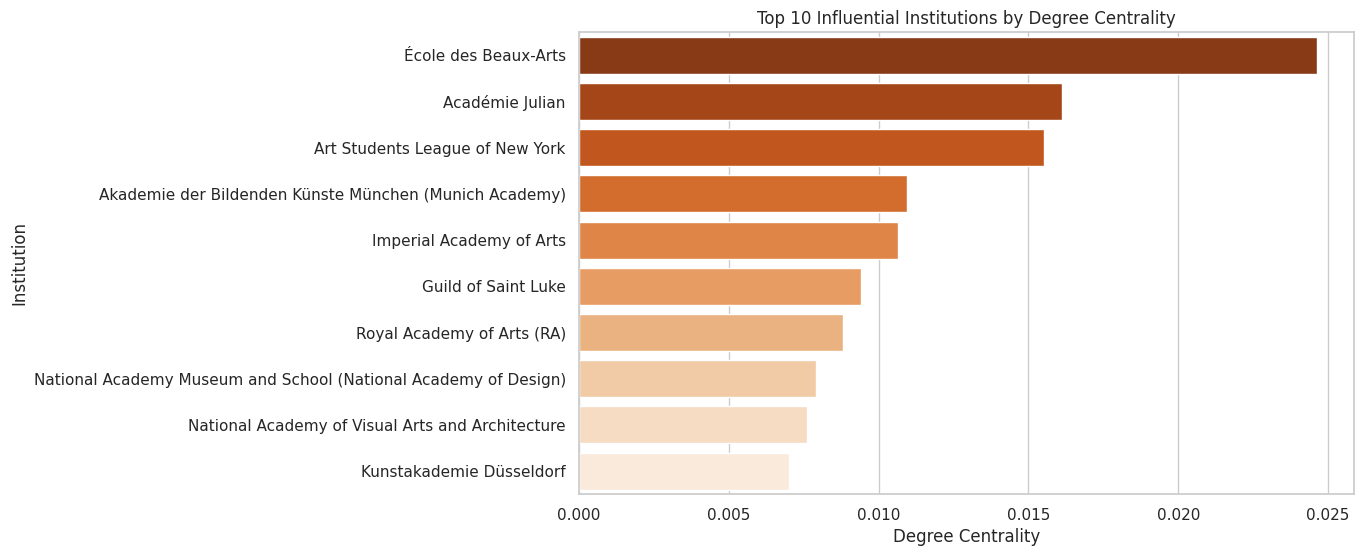

In [35]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Visualize the Most Influential Institutions by Degree Centrality
def plot_top_institutions(institutions):
    institutions_df = pd.DataFrame(institutions, columns=['Institution', 'Centrality'])
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Centrality', y='Institution', data=institutions_df, palette='Oranges_r')
    plt.title('Top 10 Influential Institutions by Degree Centrality')
    plt.xlabel('Degree Centrality')
    plt.ylabel('Institution')
    plt.show()

top_institutions_list = [(G.nodes[node]['title'], value) for node, value in top_institutions]
plot_top_institutions(top_institutions_list)


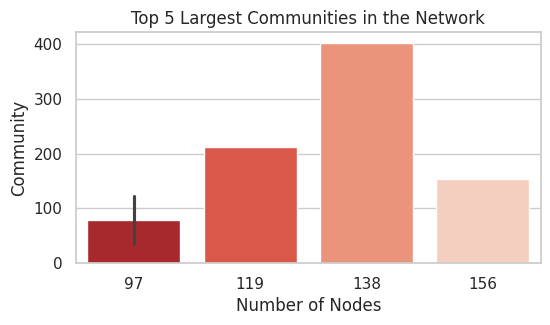

In [39]:
# Visualize the Largest Communities in the Network
def plot_communities(community_sizes):
    community_sizes_df = pd.DataFrame(community_sizes.most_common(5), columns=['Community', 'Size'])
    plt.figure(figsize=(6, 3))  # Reduced figure size
    sns.barplot(x='Size', y='Community', data=community_sizes_df, palette='Reds_r')
    plt.title('Top 5 Largest Communities in the Network')
    plt.xlabel('Number of Nodes')
    plt.ylabel('Community')
    plt.show()
plot_communities(community_sizes)

1. The most influential artists are determined by their centrality measures:
   - Degree Centrality shows artists with the most direct connections.
   - Betweenness Centrality highlights artists who bridge different parts of the network.
   - Eigenvector Centrality identifies artists connected to other influential artists.

2. The most influential movements are determined by counting how many artists are connected to each school or movement.
3. The most influential institutions are those with the highest degree centrality, indicating they are well-connected to many artists.
4. The nationalities that concentrate the majority of artists show the most common origins of artists in the dataset.
5. The biggest communities in the network are detected using the Louvain method, which identifies clusters of nodes that are more densely connected within themselves than with the rest of the network.